**Import libraries.**

In [55]:
import csv
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


**Declare functions.**

In [56]:
def new_units_in_shop(turn=8, hero="Apocalipse", locked_units=0, locked_spells=0):
    base_spells = 1
    if hero == "Potion Master":
        base_spells += 1
    elif hero == "Loki":
        base_spells -= 1
    
    if turn <= 2:
        base_units = 3
    elif turn <= 6:
        base_units = 4
    elif turn >= 7:
        base_units = 5
    
    if hero == "Pied Piper":
        base_units += 1

    locked_slots = locked_units + max(base_spells, locked_spells)

    units = min(base_units, 7-locked_slots)    

    return units

def current_level(turn=0, xp=0):
    level = 2
    level += int((turn-1 + xp)/3)

    return min(level, 6)

def chances_of_finding_unit(unit_level=6, current_level=6, turn=20, hero="Apocalipse", locked_units=0, locked_spells=0, out_of_pool=0, number_of_characters=1):
    if unit_level > current_level:
        print("You can't find a unit of a level higher than yours in your shops naturally.")
        return 0

    if hero == "Pan's Shadow" and current_level >= 4:
        possible_chars = len(pool_chars.loc[pool_chars["Level"] <= str(current_level)])
        possible_chars -= len(pool_chars.loc[pool_chars["Level"] <= str(3)])
    elif hero == "Pied Piper":
        pool_animals = pool_chars.loc[pool_chars["Types"] == "Animal"]
        possible_animals = len(pool_animals.loc[pool_animals["Level"] <= str(current_level)])
        possible_chars = len(pool_chars.loc[pool_chars["Level"] <= str(current_level)])
    else:
        possible_chars = len(pool_chars.loc[pool_chars["Level"] <= str(current_level)])

    if unit_level < 6:
        chance = (number_of_characters*(15-out_of_pool))/possible_chars
    else:
        chance = (number_of_characters*(10-out_of_pool))/possible_chars
        
    new_unit_slots = new_units_in_shop(turn, hero, locked_units, locked_spells)
    if hero == "Pied Piper":
        new_unit_slots -= 1
        
        if unit_level < 6:
            animal_chance = (number_of_characters*(15-out_of_pool))/possible_animals
        else:
            animal_chance = (number_of_characters*(10-out_of_pool))/possible_animals
        
    chance_of_not_hitting = (1 - chance)
    full_shop_chance =  1 - (chance_of_not_hitting ** new_unit_slots)

    if hero == "Pied Piper":
        full_shop_chance += animal_chance
        
    chance = chance * 100
    full_shop_chance = full_shop_chance * 100

    print(f'Number of available units of level {current_level} or lower: {possible_chars}')
    print(f'Chances of finding one specific unit of level {unit_level} per slot: {chance:.2f}%')
    if hero == "Pied Piper":
        animal_chance = animal_chance * 100
        print(f'Chances of finding one specific animal of level {unit_level} on Piper slot: {animal_chance:.2f}%')
    print(f'Number of new units that will appear on shop: {new_unit_slots}')
    print(f'Chance of finding at least one of the specific unit on each shop: {full_shop_chance:.2f}%')
    return full_shop_chance

def chances_of_finding_treasure(level=6, number_looking_for=1, out_of_pool=0):
    amount_of_treasures = len(treasures.loc[treasures["Level"] == str(level)]) - out_of_pool
    chance = number_looking_for/amount_of_treasures
    chance_2 =  number_looking_for/(amount_of_treasures-1)
    chance_3 = number_looking_for/(amount_of_treasures-2)
    final_chance = chance + chance_2 + chance_3
    for i in range(number_looking_for):
        final_chance -= (number_looking_for/amount_of_treasures) * (number_looking_for-(i+1))/(amount_of_treasures-(i+1))

    final_chance = final_chance * 100
    chance = chance * 100

    print(f'Number of available treasures of level {level}: {amount_of_treasures}')
    print(f'Chances of finding (at least one of) the specific treasure(s) of level {level} per slot: {chance:.2f}%')
    print(f'Chance of the finding (at least one of) the specific treasure(s) you want out of 3 options: {final_chance:.2f}%')
    return final_chance

def chances_of_finding_spell(level=6, number_looking_for=1, hero="Apocalypse"):
    amount_of_spells = len(spells.loc[spells["Level"] <= str(level)])
    if level == 6:
        amount_of_spells -= 3
        
    chance = number_looking_for/amount_of_spells
    
    if hero == "Potion Master":
        final_chance = chance + number_looking_for/(amount_of_spells-1)  
    else: 
        final_chance = chance
    chance = chance * 100
    final_chance = final_chance * 100

    print(f'Number of available spells of level {level}: {amount_of_spells}')
    print(f'Chances of finding (at least one of) the specific spell(s) of level {level} per spell slot: {chance:.2f}%')
    print(f'Chance of the finding (at least one of) the specific spell(s) you want: {final_chance:.2f}%')
    return final_chance

**Import data.**

In [57]:
heroes = []
with open("heroes.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for row in reader:
        heroes.append(row)
heroes = pd.DataFrame(heroes)
heroes.columns = ["Hero", "Health", "Ability"]

In [58]:
spells = []
with open("spells.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for row in reader:
        spells.append(row)
spells = pd.DataFrame(spells)
spells.columns = ["Spell", "Level", "Cost", "Effect"]

In [59]:
treasures = []
with open("treasures.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for row in reader:
        treasures.append(row)
treasures = pd.DataFrame(treasures)
treasures.columns = ["Treasure", "Level", "Effect"]

In [60]:
chars = []
with open("chars.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for row in reader:
        chars.append(row)

chars = pd.DataFrame(chars)
chars.columns = ["Character", "Level", "Attack", "Health", "Alignment", "Types", "Ability", "Upgraded Ability"]
chars = chars[chars.Level != 'Created']
reps = [10 if val=='6' else 15 for val in chars.Level]
pool_chars = chars.loc[np.repeat(chars.index.values, reps)]

In [61]:
chars

,Character,Level,Attack,Health,Alignment,Types,Ability,Upgraded Ability
0,B-a-a-d Billy Gruff,2,2,3,Evil,Animal,,
1,Baby Dragon,2,3,2,Neutral,Dragon,Flying,Flying
2,Baby Root,2,0,3,Good,Treant,Support: +3 Health,Support: +6 Health
3,Black Cat,2,1,1,Evil,Animal,Last Breath: Summon a 1/1 Cat.,Last Breath: Summon a 2/2 Cat.
4,Blind Mouse,2,2,2,Neutral,Animal,Find 3 Blind Mice to get a level 4 treasure in...,
...,...,...,...,...,...,...,...,...
86,Hercules,6,20,20,Good,Royal,Quest: I deal 100 damage.,Quest: I deal 100 damage.
87,Jormungand,6,20,20,Neutral,Monster,When another one of your characters triggers a...,When another one of your characters triggers a...
88,Lordy,6,7,7,Neutral,Dwarf,"At the start of each brawl, for each Dwarf you...","At the start of each brawl, for each Dwarf you..."
89,Scion of the Storm,6,2,2,Neutral,Mage,+2/+2 for each spell you have cast this game.,+4/+4 for each spell you have cast this game.


In [62]:
chars.describe()

,Character,Level,Attack,Health,Alignment,Types,Ability,Upgraded Ability
count,91,91,91,91,91,91,91,89
unique,91,5,11,15,3,15,89,85
top,B-a-a-d Billy Gruff,4,2,3,Good,Animal,,
freq,1,23,18,17,34,17,3,5


In [63]:
pool_chars

,Character,Level,Attack,Health,Alignment,Types,Ability,Upgraded Ability
0,B-a-a-d Billy Gruff,2,2,3,Evil,Animal,,
0,B-a-a-d Billy Gruff,2,2,3,Evil,Animal,,
0,B-a-a-d Billy Gruff,2,2,3,Evil,Animal,,
0,B-a-a-d Billy Gruff,2,2,3,Evil,Animal,,
0,B-a-a-d Billy Gruff,2,2,3,Evil,Animal,,
...,...,...,...,...,...,...,...,...
90,The Green Knight,6,10,30,Good,Treant,Support: +10 Health,Support: +20 Health
90,The Green Knight,6,10,30,Good,Treant,Support: +10 Health,Support: +20 Health
90,The Green Knight,6,10,30,Good,Treant,Support: +10 Health,Support: +20 Health
90,The Green Knight,6,10,30,Good,Treant,Support: +10 Health,Support: +20 Health


**Percentages of units of each level on the shop at each hero level.**

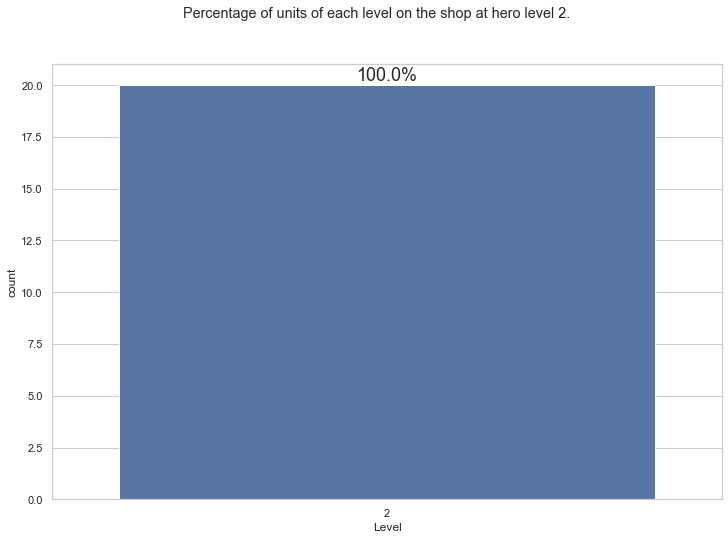

In [64]:
sns.set_theme(style="whitegrid")

def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 
        y = p.get_y() + p.get_height() + (p.get_height()*0.01)
        ax.text(x, y, percentage, ha="center", size=18)

plt.figure(figsize= (12, 8))

ax = sns.countplot(x='Level', data = chars.loc[chars["Level"] <= str(2)])
ax.figure.suptitle("Percentage of units of each level on the shop at hero level 2.")
without_hue(ax, chars.loc[chars["Level"] <= str(2)])

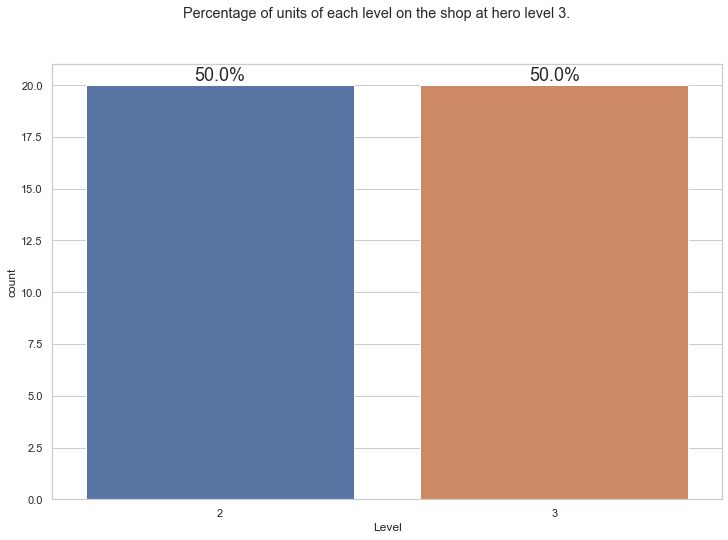

In [65]:
plt.figure(figsize= (12, 8))

ax = sns.countplot(x='Level', data = chars.loc[chars["Level"] <= str(3)])
ax.figure.suptitle("Percentage of units of each level on the shop at hero level 3.")
without_hue(ax, chars.loc[chars["Level"] <= str(3)])

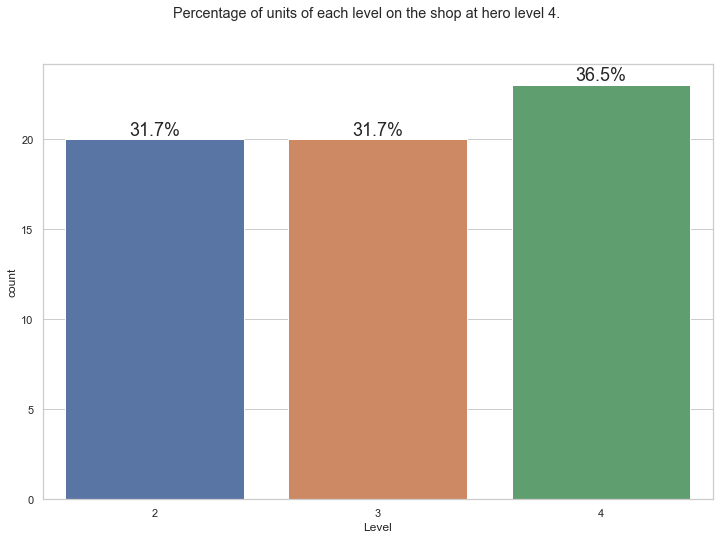

In [66]:
plt.figure(figsize= (12, 8))

ax = sns.countplot(x='Level', data = chars.loc[chars["Level"] <= str(4)])
ax.figure.suptitle("Percentage of units of each level on the shop at hero level 4.")
without_hue(ax, chars.loc[chars["Level"] <= str(4)])

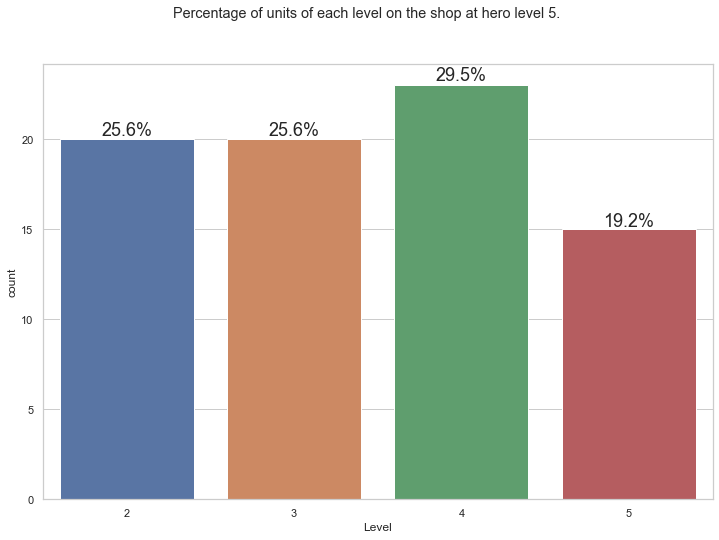

In [67]:
plt.figure(figsize= (12, 8))

ax = sns.countplot(x='Level', data = chars.loc[chars["Level"] <= str(5)])
ax.figure.suptitle("Percentage of units of each level on the shop at hero level 5.")
without_hue(ax, chars.loc[chars["Level"] <= str(5)])

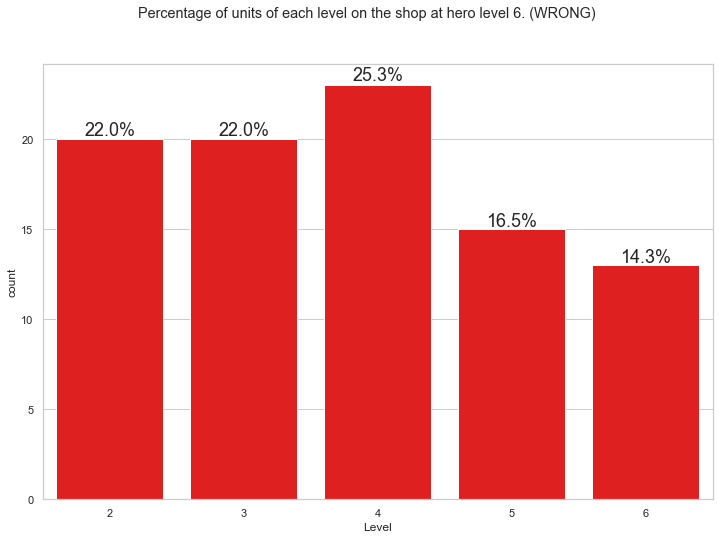

In [68]:
plt.figure(figsize= (12, 8))

ax = sns.countplot(x='Level', data = chars, color="Red")
ax.figure.suptitle("Percentage of units of each level on the shop at hero level 6. (WRONG)")
without_hue(ax, chars)

But we need to consider that we have only 10 copies of each level 6 unit, instead of the usual 15. So the adjusted numbers are:

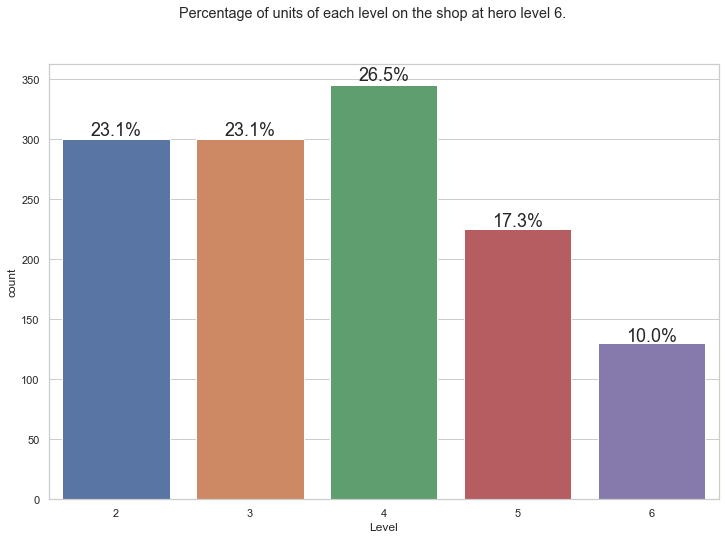

In [69]:
plt.figure(figsize= (12, 8))

ax = sns.countplot(x='Level', data = pool_chars)
ax.figure.suptitle("Percentage of units of each level on the shop at hero level 6.")
without_hue(ax, pool_chars)

**Chances of finding at least one specific unit of current level on shop.**

In [70]:
_ = chances_of_finding_unit(unit_level=2, current_level=2, turn=1, hero="Apocalypse", locked_units=0, locked_spells=0, out_of_pool=0)   

Number of available units of level 2 or lower: 300
Chances of finding one specific unit of level 2 per slot: 5.00%
Number of new units that will appear on shop: 3
Chance of finding at least one of the specific unit on each shop: 14.26%


In [71]:
chances = []
last_lvl = 0
for turn in range(1, 20):
    level = current_level(turn, 0)
    if last_lvl != level:
        chances.append(chances_of_finding_unit(unit_level=level, current_level=level, turn=turn))
        last_lvl = level
        print("")


x = [2, 3, 4, 5, 6]
chances = pd.DataFrame(chances)
chances['Level'] = x
chances.columns = ["Chances of finding at least one specific unit of current level on shop.", "Level"]

Number of available units of level 2 or lower: 300
Chances of finding one specific unit of level 2 per slot: 5.00%
Number of new units that will appear on shop: 3
Chance of finding at least one of the specific unit on each shop: 14.26%

Number of available units of level 3 or lower: 600
Chances of finding one specific unit of level 3 per slot: 2.50%
Number of new units that will appear on shop: 4
Chance of finding at least one of the specific unit on each shop: 9.63%

Number of available units of level 4 or lower: 945
Chances of finding one specific unit of level 4 per slot: 1.59%
Number of new units that will appear on shop: 5
Chance of finding at least one of the specific unit on each shop: 7.69%

Number of available units of level 5 or lower: 1170
Chances of finding one specific unit of level 5 per slot: 1.28%
Number of new units that will appear on shop: 5
Chance of finding at least one of the specific unit on each shop: 6.25%

Number of available units of level 6 or lower: 1300
Ch

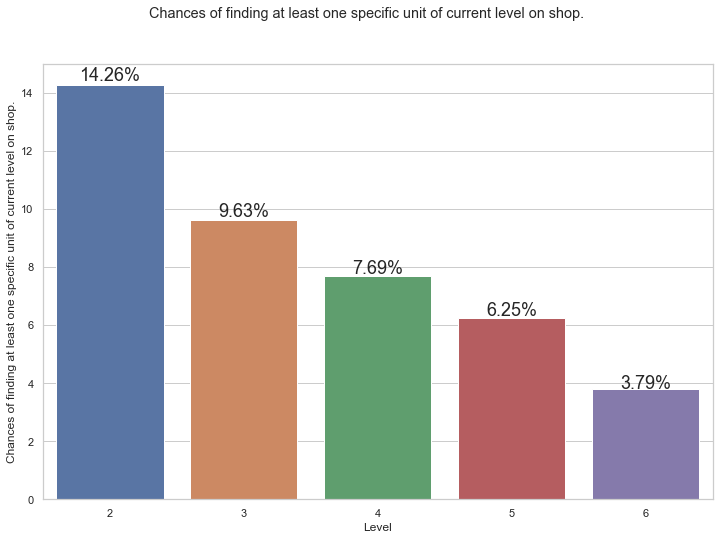

In [72]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(y="Chances of finding at least one specific unit of current level on shop.", x="Level", data=chances)
ax.figure.suptitle("Chances of finding at least one specific unit of current level on shop.")

for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    y_plus = p.get_y() + p.get_height() + (p.get_height()*0.01)
    ax.text(x, y_plus, '{:.2f}%'.format(y), ha='center', size = 18)

So if you're specifically searching for Ashwood elm on level 6, you have close to 4% chances of finding it per shop.

This aproximation does not consider if any of the units are already out of the pool, so the true values are usually a little lower than presented here.

Values might also change if you lock the shops, play certain spells, are playing certain heroes, or have certain treasures. We'll be taking a look at some of those scenarios now.


**Pied Piper.**

In [73]:
_ = chances_of_finding_unit(unit_level=2, current_level=2, turn=1, hero="Pied Piper", locked_units=0, locked_spells=0, out_of_pool=0) 

Number of available units of level 2 or lower: 300
Chances of finding one specific unit of level 2 per slot: 5.00%
Chances of finding one specific animal of level 2 on Piper slot: 14.29%
Number of new units that will appear on shop: 3
Chance of finding at least one of the specific unit on each shop: 28.55%


In [74]:
chances = []
last_lvl = 0
for turn in range(1, 20):
    level = current_level(turn, 0)
    if last_lvl != level:
        chances.append(chances_of_finding_unit(unit_level=level, current_level=level, turn=turn, hero="Pied Piper"))
        last_lvl = level
        print("")


x = [2, 3, 4, 5, 6]
chances = pd.DataFrame(chances)
chances['Level'] = x
chances.columns = ["Chances of finding at least one specific animal of current level on shop as Pied Piper.", "Level"]

Number of available units of level 2 or lower: 300
Chances of finding one specific unit of level 2 per slot: 5.00%
Chances of finding one specific animal of level 2 on Piper slot: 14.29%
Number of new units that will appear on shop: 3
Chance of finding at least one of the specific unit on each shop: 28.55%

Number of available units of level 3 or lower: 600
Chances of finding one specific unit of level 3 per slot: 2.50%
Chances of finding one specific animal of level 3 on Piper slot: 10.00%
Number of new units that will appear on shop: 4
Chance of finding at least one of the specific unit on each shop: 19.63%

Number of available units of level 4 or lower: 945
Chances of finding one specific unit of level 4 per slot: 1.59%
Chances of finding one specific animal of level 4 on Piper slot: 7.69%
Number of new units that will appear on shop: 5
Chance of finding at least one of the specific unit on each shop: 15.38%

Number of available units of level 5 or lower: 1170
Chances of finding one

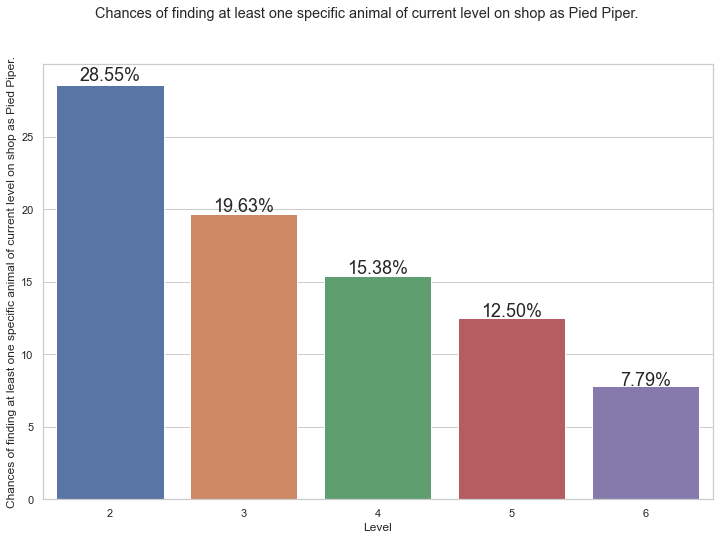

In [75]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(y="Chances of finding at least one specific animal of current level on shop as Pied Piper.", x="Level", data=chances)
ax.figure.suptitle("Chances of finding at least one specific animal of current level on shop as Pied Piper.")

for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    y_plus = p.get_y() + p.get_height() + (p.get_height()*0.01)
    ax.text(x, y_plus, '{:.2f}%'.format(y), ha='center', size = 18)

If you're looking for specific animals of same level as you are, you're around twice as likely to find them on piper at any stage of the game.


So, if you're looking for good boy specifically at level 6, you have around 8% chances of finding him per shop on pied piper, as oposed to the usual 4% on other heroes. Or as oposed to the 4% chances of finding a specific non-animal 6 drop as Pied Piper.

**Pan's shadow/Staff of the Old Toad.**

In [76]:
a = chances_of_finding_unit(unit_level=4, current_level=4, turn=10, hero="Pan's Shadow", locked_units=0, locked_spells=0, out_of_pool=0)   

Number of available units of level 4 or lower: 345
Chances of finding one specific unit of level 4 per slot: 4.35%
Number of new units that will appear on shop: 5
Chance of finding at least one of the specific unit on each shop: 19.93%


In [77]:
chances = []
last_lvl = 0
for turn in range(7, 20):
    level = current_level(turn, 0)
    if last_lvl != level:
        chances.append(chances_of_finding_unit(unit_level=level, current_level=level, turn=turn, hero="Pan's Shadow", locked_units=0, locked_spells=0, out_of_pool=0))
        last_lvl = level
        print("")


x = [4, 5, 6]
chances = pd.DataFrame(chances)
chances['Level'] = x
chances.columns = ["Chances of finding at least one specific unit of current level on shop", "Level"]

Number of available units of level 4 or lower: 345
Chances of finding one specific unit of level 4 per slot: 4.35%
Number of new units that will appear on shop: 5
Chance of finding at least one of the specific unit on each shop: 19.93%

Number of available units of level 5 or lower: 570
Chances of finding one specific unit of level 5 per slot: 2.63%
Number of new units that will appear on shop: 5
Chance of finding at least one of the specific unit on each shop: 12.48%

Number of available units of level 6 or lower: 700
Chances of finding one specific unit of level 6 per slot: 1.43%
Number of new units that will appear on shop: 5
Chance of finding at least one of the specific unit on each shop: 6.94%



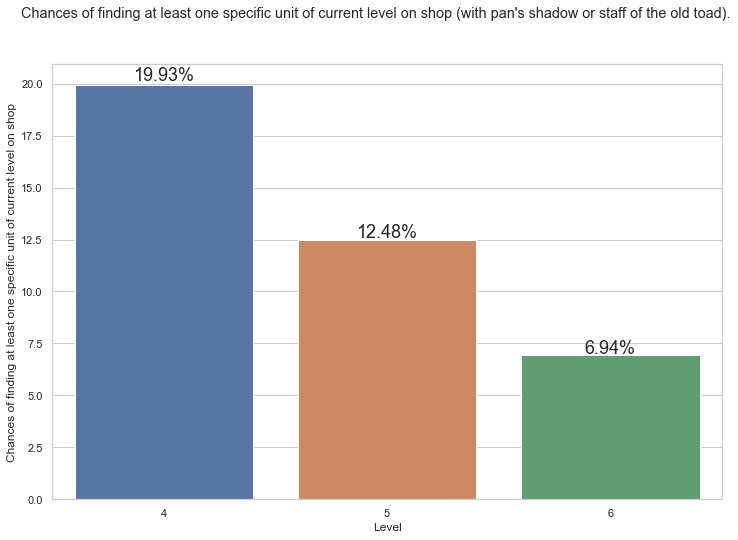

In [78]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(y="Chances of finding at least one specific unit of current level on shop", x="Level", data=chances)
ax.figure.suptitle("Chances of finding at least one specific unit of current level on shop (with pan's shadow or staff of the old toad).")

for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    y_plus = p.get_y() + p.get_height() + (p.get_height()*0.01)
    ax.text(x, y_plus, '{:.2f}%'.format(y), ha='center', size = 18)

**Wonder Waddle.**

In [79]:
animals = chars.loc[chars["Types"] == "Animal"]

In [80]:
animals = animals.loc[animals["Level"] <= str(3)]
animals

,Character,Level,Attack,Health,Alignment,Types,Ability,Upgraded Ability
0,B-a-a-d Billy Gruff,2,2,3,Evil,Animal,,
3,Black Cat,2,1,1,Evil,Animal,Last Breath: Summon a 1/1 Cat.,Last Breath: Summon a 2/2 Cat.
4,Blind Mouse,2,2,2,Neutral,Animal,Find 3 Blind Mice to get a level 4 treasure in...,
8,Golden Chicken,2,2,2,Neutral,Animal,I sell for 2 Gold.,I sell for 4 Gold.
11,Kitty Cutpurse,2,1,1,Evil,Animal,Slay: +1 Gold,Slay: +2 Gold
15,Polywoggle,2,1,1,Neutral,Animal,Slay: I transform into a character that is one...,Slay: I transform into an Upgraded character t...
16,Rainbow Unicorn,2,1,5,Good,Animal,Your other Good characters have +1 Health.,Your other Good characters have +2 Health.
28,Prized Pig,3,3,6,Neutral,Animal,"When I survive a brawl, +2 Gold.Last Breath: G...","When I survive a brawl, +4 Gold. Last Breath: ..."
34,The White Stag,3,3,3,Good,Animal,"When I attack, give the characters behind me +...","When I attack, give the characters behind me +..."
35,Trojan Donkey,3,2,6,Good,Animal,"When I survive damage, summon a random character.","When I survive damage, summon a random charact..."


In [81]:
animals = []
animals.append(chances_of_finding_unit(unit_level=3, current_level=3, turn=4, hero="Wonder Waddle", locked_units=0, locked_spells=0, out_of_pool=0, number_of_characters=3))
print()
animals.append(chances_of_finding_unit(unit_level=3, current_level=4, turn=7, hero="Wonder Waddle", locked_units=0, locked_spells=0, out_of_pool=0, number_of_characters=3))
print()
animals.append(chances_of_finding_unit(unit_level=3, current_level=5, turn=9, hero="Wonder Waddle", locked_units=0, locked_spells=0, out_of_pool=0, number_of_characters=3))
print()
animals.append(chances_of_finding_unit(unit_level=3, current_level=6, turn=12, hero="Wonder Waddle", locked_units=0, locked_spells=0, out_of_pool=0, number_of_characters=3))

x = [3, 4, 5, 6]
animals = pd.DataFrame(animals)
animals['Level'] = x
animals.columns = ["Chances of finding at least one 3 cost animal unit per shop, on each level", "Level"]


Number of available units of level 3 or lower: 600
Chances of finding one specific unit of level 3 per slot: 7.50%
Number of new units that will appear on shop: 4
Chance of finding at least one of the specific unit on each shop: 26.79%

Number of available units of level 4 or lower: 945
Chances of finding one specific unit of level 3 per slot: 4.76%
Number of new units that will appear on shop: 5
Chance of finding at least one of the specific unit on each shop: 21.65%

Number of available units of level 5 or lower: 1170
Chances of finding one specific unit of level 3 per slot: 3.85%
Number of new units that will appear on shop: 5
Chance of finding at least one of the specific unit on each shop: 17.81%

Number of available units of level 6 or lower: 1300
Chances of finding one specific unit of level 3 per slot: 3.46%
Number of new units that will appear on shop: 5
Chance of finding at least one of the specific unit on each shop: 16.15%


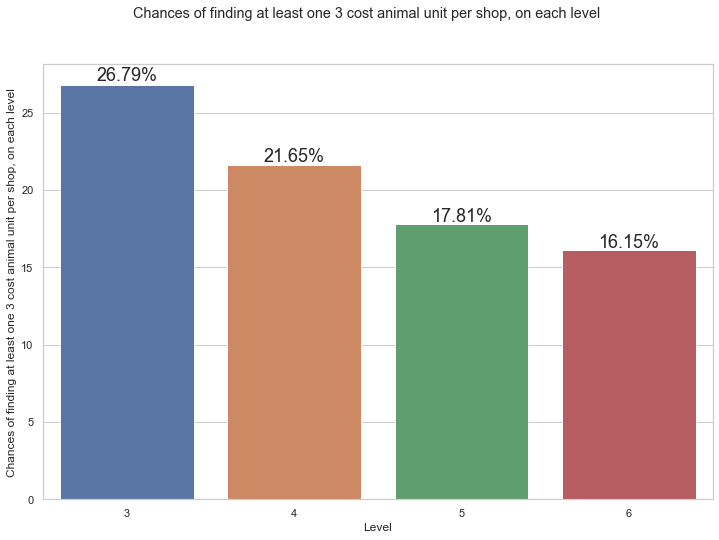

In [82]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(y="Chances of finding at least one 3 cost animal unit per shop, on each level", x="Level", data=animals)
ax.figure.suptitle("Chances of finding at least one 3 cost animal unit per shop, on each level")

for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    y_plus = p.get_y() + p.get_height() + (p.get_height()*0.01)
    ax.text(x, y_plus, '{:.2f}%'.format(y), ha='center', size = 18)

In [83]:
animals = []
x = [2, 3, 4, 5, 6]
animals.append(chances_of_finding_unit(unit_level=2, current_level=2, turn=1, hero="Wonder Waddle", locked_units=0, locked_spells=0, out_of_pool=0, number_of_characters=7))
print()
animals.append(chances_of_finding_unit(unit_level=2, current_level=3, turn=4, hero="Wonder Waddle", locked_units=0, locked_spells=0, out_of_pool=0, number_of_characters=10))
print()
animals.append(chances_of_finding_unit(unit_level=2, current_level=4, turn=7, hero="Wonder Waddle", locked_units=0, locked_spells=0, out_of_pool=0, number_of_characters=10))
print()
animals.append(chances_of_finding_unit(unit_level=2, current_level=5, turn=9, hero="Wonder Waddle", locked_units=0, locked_spells=0, out_of_pool=0, number_of_characters=10))
print()
animals.append(chances_of_finding_unit(unit_level=2, current_level=6, turn=12, hero="Wonder Waddle", locked_units=0, locked_spells=0, out_of_pool=0, number_of_characters=10))
animals = pd.DataFrame(animals)

animals['Level'] = x
animals.columns = ["Chances of finding at least one 2 or 3 cost animal unit per shop, on each level", "Level"]


Number of available units of level 2 or lower: 300
Chances of finding one specific unit of level 2 per slot: 35.00%
Number of new units that will appear on shop: 3
Chance of finding at least one of the specific unit on each shop: 72.54%

Number of available units of level 3 or lower: 600
Chances of finding one specific unit of level 2 per slot: 25.00%
Number of new units that will appear on shop: 4
Chance of finding at least one of the specific unit on each shop: 68.36%

Number of available units of level 4 or lower: 945
Chances of finding one specific unit of level 2 per slot: 15.87%
Number of new units that will appear on shop: 5
Chance of finding at least one of the specific unit on each shop: 57.86%

Number of available units of level 5 or lower: 1170
Chances of finding one specific unit of level 2 per slot: 12.82%
Number of new units that will appear on shop: 5
Chance of finding at least one of the specific unit on each shop: 49.64%

Number of available units of level 6 or lower: 

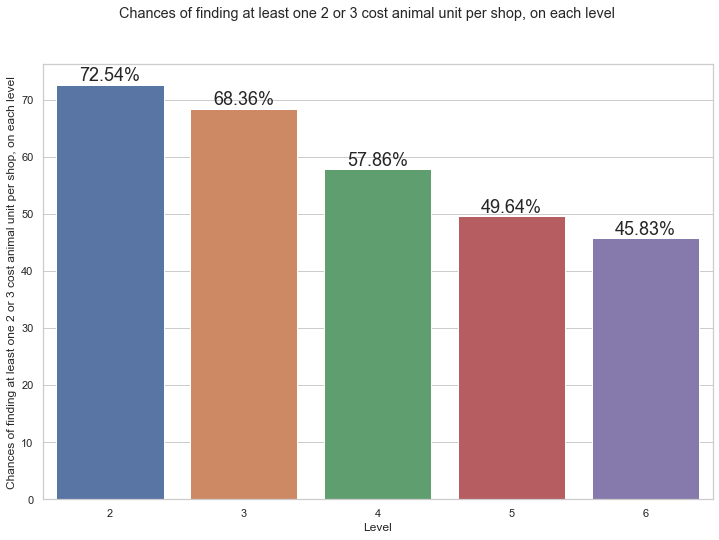

In [84]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(y="Chances of finding at least one 2 or 3 cost animal unit per shop, on each level", x="Level", data=animals)
ax.figure.suptitle("Chances of finding at least one 2 or 3 cost animal unit per shop, on each level")

for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    y_plus = p.get_y() + p.get_height() + (p.get_height()*0.01)
    ax.text(x, y_plus, '{:.2f}%'.format(y), ha='center', size = 18)

**Treasures.**

In [85]:
a = chances_of_finding_treasure(level=2, number_looking_for=1, out_of_pool=0)

Number of available treasures of level 2: 23
Chances of finding (at least one of) the specific treasure(s) of level 2 per slot: 4.35%
Chance of the finding (at least one of) the specific treasure(s) you want out of 3 options: 13.66%


In [86]:
levels = [2, 3, 4, 5, 6]
chances = []
for level in levels:
    chances.append(chances_of_finding_treasure(level=level))
    print()

chances = pd.DataFrame(chances)
chances['Level'] = levels
chances.columns = ["Chances of finding the specific treasure you're looking for, on each level.", "Level"]

Number of available treasures of level 2: 23
Chances of finding (at least one of) the specific treasure(s) of level 2 per slot: 4.35%
Chance of the finding (at least one of) the specific treasure(s) you want out of 3 options: 13.66%

Number of available treasures of level 3: 15
Chances of finding (at least one of) the specific treasure(s) of level 3 per slot: 6.67%
Chance of the finding (at least one of) the specific treasure(s) you want out of 3 options: 21.50%

Number of available treasures of level 4: 12
Chances of finding (at least one of) the specific treasure(s) of level 4 per slot: 8.33%
Chance of the finding (at least one of) the specific treasure(s) you want out of 3 options: 27.42%

Number of available treasures of level 5: 8
Chances of finding (at least one of) the specific treasure(s) of level 5 per slot: 12.50%
Chance of the finding (at least one of) the specific treasure(s) you want out of 3 options: 43.45%

Number of available treasures of level 6: 10
Chances of finding 

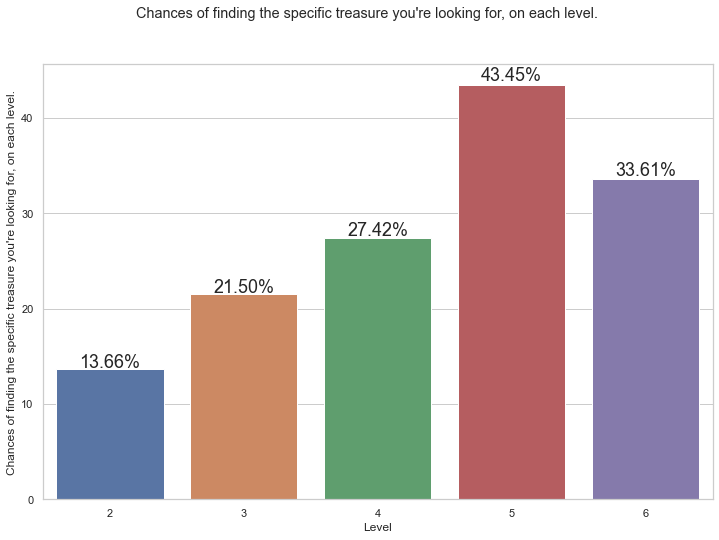

In [87]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(y="Chances of finding the specific treasure you're looking for, on each level.", x="Level", data=chances)
ax.figure.suptitle("Chances of finding the specific treasure you're looking for, on each level.")

for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    y_plus = p.get_y() + p.get_height() + (p.get_height()*0.01)
    ax.text(x, y_plus, '{:.2f}%'.format(y), ha='center', size = 18)

**Merlin's Hat + Crystal Ball.**

In [88]:
hat = chances_of_finding_treasure(level=3, number_looking_for=2, out_of_pool=0) / 100
print()
ball = chances_of_finding_treasure(level=3, number_looking_for=1, out_of_pool=1) / 100
print()

find_asap = (hat * ball)*100
print(f"Chance to find hat + ball in the first two treasure selections: {find_asap:.2f}%")



Number of available treasures of level 3: 15
Chances of finding (at least one of) the specific treasure(s) of level 3 per slot: 13.33%
Chance of the finding (at least one of) the specific treasure(s) you want out of 3 options: 42.05%

Number of available treasures of level 3: 14
Chances of finding (at least one of) the specific treasure(s) of level 3 per slot: 7.14%
Chance of the finding (at least one of) the specific treasure(s) you want out of 3 options: 23.17%

Chance to find hat + ball in the first two treasure selections: 9.74%


In [89]:
first = chances_of_finding_treasure(level=3, number_looking_for=2, out_of_pool=0) / 100
print()
second = chances_of_finding_treasure(level=3, number_looking_for=2, out_of_pool=1) / 100
print()
third = chances_of_finding_treasure(level=3, number_looking_for=1, out_of_pool=2) / 100
print()

print(f"{(first * second * third * 100):.2f}%")
print()

other_first = chances_of_finding_treasure(level=3, number_looking_for=2, out_of_pool=0) / 100
print()
other_second = chances_of_finding_treasure(level=3, number_looking_for=1, out_of_pool=1) / 100
print()
other_third = chances_of_finding_treasure(level=3, number_looking_for=1, out_of_pool=2) / 100
print()
print(f"{(other_first * other_second * other_third * 100):.2f}%")
print()

chance = (first * second * third * 100 ) + (other_first * other_second * other_third * 100) + find_asap
print(f"Chance to find hat + ball in the first three treasure selections: {chance:.2f}%")



Number of available treasures of level 3: 15
Chances of finding (at least one of) the specific treasure(s) of level 3 per slot: 13.33%
Chance of the finding (at least one of) the specific treasure(s) you want out of 3 options: 42.05%

Number of available treasures of level 3: 14
Chances of finding (at least one of) the specific treasure(s) of level 3 per slot: 14.29%
Chance of the finding (at least one of) the specific treasure(s) you want out of 3 options: 45.24%

Number of available treasures of level 3: 13
Chances of finding (at least one of) the specific treasure(s) of level 3 per slot: 7.69%
Chance of the finding (at least one of) the specific treasure(s) you want out of 3 options: 25.12%

4.78%

Number of available treasures of level 3: 15
Chances of finding (at least one of) the specific treasure(s) of level 3 per slot: 13.33%
Chance of the finding (at least one of) the specific treasure(s) you want out of 3 options: 42.05%

Number of available treasures of level 3: 14
Chances o

In [90]:
def getnums(start=1, end=len(treasures.loc[treasures["Level"] == "3"]), interval=1):
    return(list(range(start, end+1, interval)))

treasures_list = getnums()

In [91]:
combinations = list(itertools.combinations(treasures_list, 2))

In [92]:
hat_ball_combos = []
for i in range(1, 16, 1):
    print(f"Currently analysing {i}: ")
    for combo in combinations:
        if combo[1] == i:
            hat_ball_combos.append(combo)
            print(combo) 
    print()


Currently analysing 1: 

Currently analysing 2: 
(1, 2)

Currently analysing 3: 
(1, 3)
(2, 3)

Currently analysing 4: 
(1, 4)
(2, 4)
(3, 4)

Currently analysing 5: 
(1, 5)
(2, 5)
(3, 5)
(4, 5)

Currently analysing 6: 
(1, 6)
(2, 6)
(3, 6)
(4, 6)
(5, 6)

Currently analysing 7: 
(1, 7)
(2, 7)
(3, 7)
(4, 7)
(5, 7)
(6, 7)

Currently analysing 8: 
(1, 8)
(2, 8)
(3, 8)
(4, 8)
(5, 8)
(6, 8)
(7, 8)

Currently analysing 9: 
(1, 9)
(2, 9)
(3, 9)
(4, 9)
(5, 9)
(6, 9)
(7, 9)
(8, 9)

Currently analysing 10: 
(1, 10)
(2, 10)
(3, 10)
(4, 10)
(5, 10)
(6, 10)
(7, 10)
(8, 10)
(9, 10)

Currently analysing 11: 
(1, 11)
(2, 11)
(3, 11)
(4, 11)
(5, 11)
(6, 11)
(7, 11)
(8, 11)
(9, 11)
(10, 11)

Currently analysing 12: 
(1, 12)
(2, 12)
(3, 12)
(4, 12)
(5, 12)
(6, 12)
(7, 12)
(8, 12)
(9, 12)
(10, 12)
(11, 12)

Currently analysing 13: 
(1, 13)
(2, 13)
(3, 13)
(4, 13)
(5, 13)
(6, 13)
(7, 13)
(8, 13)
(9, 13)
(10, 13)
(11, 13)
(12, 13)

Currently analysing 14: 
(1, 14)
(2, 14)
(3, 14)
(4, 14)
(5, 14)
(6, 14)
(7, 

In [93]:
combinations.sort(key=lambda row: (row[1]))
combinations

[(1, 2),
 (1, 3),
 (2, 3),
 (1, 4),
 (2, 4),
 (3, 4),
 (1, 5),
 (2, 5),
 (3, 5),
 (4, 5),
 (1, 6),
 (2, 6),
 (3, 6),
 (4, 6),
 (5, 6),
 (1, 7),
 (2, 7),
 (3, 7),
 (4, 7),
 (5, 7),
 (6, 7),
 (1, 8),
 (2, 8),
 (3, 8),
 (4, 8),
 (5, 8),
 (6, 8),
 (7, 8),
 (1, 9),
 (2, 9),
 (3, 9),
 (4, 9),
 (5, 9),
 (6, 9),
 (7, 9),
 (8, 9),
 (1, 10),
 (2, 10),
 (3, 10),
 (4, 10),
 (5, 10),
 (6, 10),
 (7, 10),
 (8, 10),
 (9, 10),
 (1, 11),
 (2, 11),
 (3, 11),
 (4, 11),
 (5, 11),
 (6, 11),
 (7, 11),
 (8, 11),
 (9, 11),
 (10, 11),
 (1, 12),
 (2, 12),
 (3, 12),
 (4, 12),
 (5, 12),
 (6, 12),
 (7, 12),
 (8, 12),
 (9, 12),
 (10, 12),
 (11, 12),
 (1, 13),
 (2, 13),
 (3, 13),
 (4, 13),
 (5, 13),
 (6, 13),
 (7, 13),
 (8, 13),
 (9, 13),
 (10, 13),
 (11, 13),
 (12, 13),
 (1, 14),
 (2, 14),
 (3, 14),
 (4, 14),
 (5, 14),
 (6, 14),
 (7, 14),
 (8, 14),
 (9, 14),
 (10, 14),
 (11, 14),
 (12, 14),
 (13, 14),
 (1, 15),
 (2, 15),
 (3, 15),
 (4, 15),
 (5, 15),
 (6, 15),
 (7, 15),
 (8, 15),
 (9, 15),
 (10, 15),
 (11, 15),
 (12

In [94]:
treasures_found = 0
last_treasures_found = 0
current_combinations = []
hat_ball_level_chances = []
walking_sum = 0
for combo in hat_ball_combos:
    treasures_found = combo[1]
    if treasures_found != last_treasures_found:
        last_treasures_found = treasures_found
        total = 1
        for element in current_combinations:
            total *= element
            walking_sum += total
        
        
        if walking_sum*100 >= 100:
            print("END")
            hat_ball_level_chances.append(100)
            break
        else:
            hat_ball_level_chances.append(walking_sum*100)
        print(f"Chance to find hat + ball by treasure selection {treasures_found-1}: {walking_sum*100:.2f}%")
        print()



    hat = chances_of_finding_treasure(level=3, number_looking_for=2, out_of_pool=combo[1]-2) / 100
    
    ball = chances_of_finding_treasure(level=3, number_looking_for=1, out_of_pool=combo[1]-1) / 100
    
    hat_ball = (hat * ball)
    current_combinations.append(hat_ball)
    
    hat_ball  = hat_ball * 100
    print(f"Chance to find hat + ball on selections {combo[0]}, {combo[1]}: {hat_ball:.2f}%")
    print()

    

Chance to find hat + ball by treasure selection 1: 0.00%

Number of available treasures of level 3: 15
Chances of finding (at least one of) the specific treasure(s) of level 3 per slot: 13.33%
Chance of the finding (at least one of) the specific treasure(s) you want out of 3 options: 42.05%
Number of available treasures of level 3: 14
Chances of finding (at least one of) the specific treasure(s) of level 3 per slot: 7.14%
Chance of the finding (at least one of) the specific treasure(s) you want out of 3 options: 23.17%
Chance to find hat + ball on selections 1, 2: 9.74%

Chance to find hat + ball by treasure selection 2: 9.74%

Number of available treasures of level 3: 14
Chances of finding (at least one of) the specific treasure(s) of level 3 per slot: 14.29%
Chance of the finding (at least one of) the specific treasure(s) you want out of 3 options: 45.24%
Number of available treasures of level 3: 13
Chances of finding (at least one of) the specific treasure(s) of level 3 per slot: 7.

In [95]:
hat_ball_level_chances.remove(0)
hat_ball_level_chances

[9.74265051188128,
 20.718063520023662,
 31.712932599973826,
 42.707860066906434,
 53.702787584052416,
 64.69771510121821,
 75.69264261838401,
 86.6875701355498,
 97.68249765271561,
 100]

In [96]:
attempts = []
for i in range(len(hat_ball_level_chances)):
    attempts.append(i+2)

In [97]:
chances = pd.DataFrame(hat_ball_level_chances)
chances['Attempt'] = attempts
chances.columns = ["Chances of finding hat ball by the Nth treasure reward.", "Attempt"]

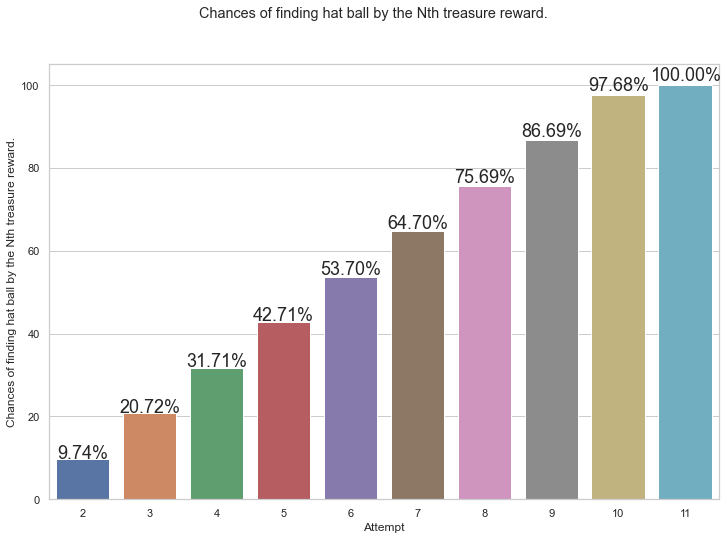

In [98]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(y="Chances of finding hat ball by the Nth treasure reward.", x="Attempt", data=chances)
ax.figure.suptitle("Chances of finding hat ball by the Nth treasure reward.")

for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    y_plus = p.get_y() + p.get_height() + (p.get_height()*0.01)
    ax.text(x, y_plus, '{:.2f}%'.format(y), ha='center', size = 18)

**Spells.**

In [99]:
_ = chances_of_finding_spell(level=2, number_looking_for=1, hero="Apocalypse")

Number of available spells of level 2: 10
Chances of finding (at least one of) the specific spell(s) of level 2 per spell slot: 10.00%
Chance of the finding (at least one of) the specific spell(s) you want: 10.00%


In [100]:
levels = [2, 3, 4, 5, 6]
chances = []
for level in levels:
    chances.append(chances_of_finding_spell(level=level))
    print()


chances = pd.DataFrame(chances)
chances['Level'] = levels
chances.columns = ["Chances of finding the specific spell you're looking for, on each level.", "Level"]

Number of available spells of level 2: 10
Chances of finding (at least one of) the specific spell(s) of level 2 per spell slot: 10.00%
Chance of the finding (at least one of) the specific spell(s) you want: 10.00%

Number of available spells of level 3: 26
Chances of finding (at least one of) the specific spell(s) of level 3 per spell slot: 3.85%
Chance of the finding (at least one of) the specific spell(s) you want: 3.85%

Number of available spells of level 4: 42
Chances of finding (at least one of) the specific spell(s) of level 4 per spell slot: 2.38%
Chance of the finding (at least one of) the specific spell(s) you want: 2.38%

Number of available spells of level 5: 45
Chances of finding (at least one of) the specific spell(s) of level 5 per spell slot: 2.22%
Chance of the finding (at least one of) the specific spell(s) you want: 2.22%

Number of available spells of level 6: 52
Chances of finding (at least one of) the specific spell(s) of level 6 per spell slot: 1.92%
Chance of th

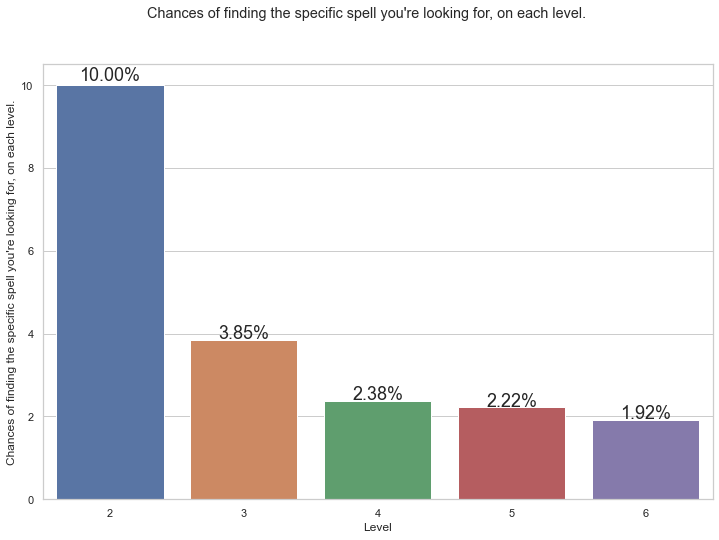

In [101]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(y="Chances of finding the specific spell you're looking for, on each level.", x="Level", data=chances)
ax.figure.suptitle("Chances of finding the specific spell you're looking for, on each level.")

for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    y_plus = p.get_y() + p.get_height() + (p.get_height()*0.01)
    ax.text(x, y_plus, '{:.2f}%'.format(y), ha='center', size = 18)

In [102]:
levels = [2, 3, 4, 5, 6]
targetables = [4, 7, 7, 0, 3] # 4 new spells - The END
targetables_sum = [4, 11, 18, 18, 22]
chances = []
i = 0
for level in levels:
    chances.append(chances_of_finding_spell(level=level, number_looking_for=targetables_sum[i]))
    print()

chances = pd.DataFrame(chances)
chances['Level'] = levels
chances.columns = ["Chances of finding targetable spells, on each level.", "Level"]

Number of available spells of level 2: 10
Chances of finding (at least one of) the specific spell(s) of level 2 per spell slot: 40.00%
Chance of the finding (at least one of) the specific spell(s) you want: 40.00%

Number of available spells of level 3: 26
Chances of finding (at least one of) the specific spell(s) of level 3 per spell slot: 15.38%
Chance of the finding (at least one of) the specific spell(s) you want: 15.38%

Number of available spells of level 4: 42
Chances of finding (at least one of) the specific spell(s) of level 4 per spell slot: 9.52%
Chance of the finding (at least one of) the specific spell(s) you want: 9.52%

Number of available spells of level 5: 45
Chances of finding (at least one of) the specific spell(s) of level 5 per spell slot: 8.89%
Chance of the finding (at least one of) the specific spell(s) you want: 8.89%

Number of available spells of level 6: 52
Chances of finding (at least one of) the specific spell(s) of level 6 per spell slot: 7.69%
Chance of 

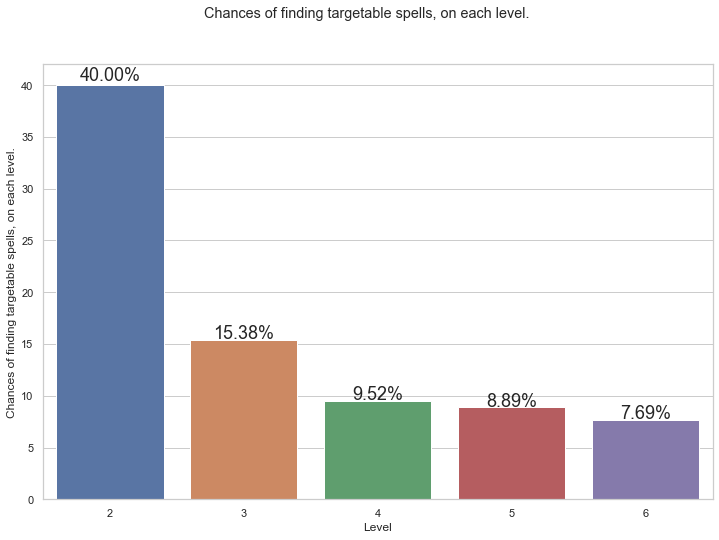

In [103]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(y="Chances of finding targetable spells, on each level.", x="Level", data=chances)
ax.figure.suptitle("Chances of finding targetable spells, on each level.")

for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    y_plus = p.get_y() + p.get_height() + (p.get_height()*0.01)
    ax.text(x, y_plus, '{:.2f}%'.format(y), ha='center', size = 18)

**Potion Master.**

In [104]:
levels = [2, 3, 4, 5, 6]
chances = []
for level in levels:
    chances.append(chances_of_finding_spell(level=level, hero="Potion Master"))
    print()


chances = pd.DataFrame(chances)
chances['Level'] = levels
chances.columns = ["Chances of finding the specific spell you're looking for, on each level as Potion Master.", "Level"]

Number of available spells of level 2: 10
Chances of finding (at least one of) the specific spell(s) of level 2 per spell slot: 10.00%
Chance of the finding (at least one of) the specific spell(s) you want: 21.11%

Number of available spells of level 3: 26
Chances of finding (at least one of) the specific spell(s) of level 3 per spell slot: 3.85%
Chance of the finding (at least one of) the specific spell(s) you want: 7.85%

Number of available spells of level 4: 42
Chances of finding (at least one of) the specific spell(s) of level 4 per spell slot: 2.38%
Chance of the finding (at least one of) the specific spell(s) you want: 4.82%

Number of available spells of level 5: 45
Chances of finding (at least one of) the specific spell(s) of level 5 per spell slot: 2.22%
Chance of the finding (at least one of) the specific spell(s) you want: 4.49%

Number of available spells of level 6: 52
Chances of finding (at least one of) the specific spell(s) of level 6 per spell slot: 1.92%
Chance of th

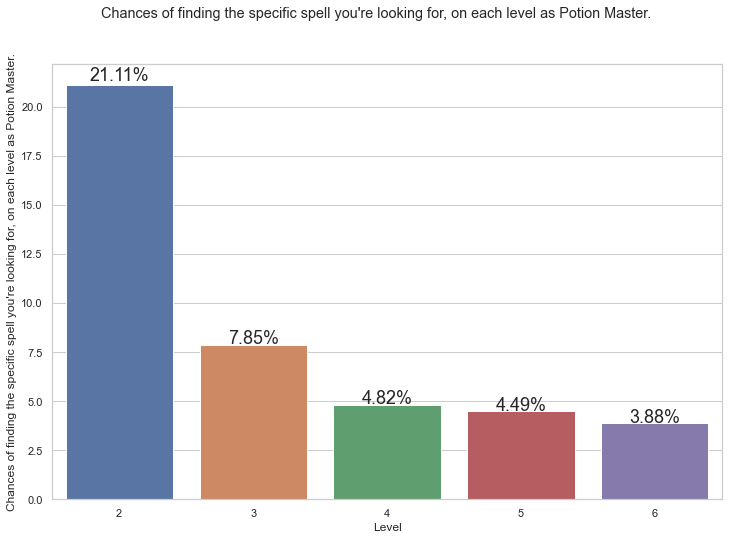

In [105]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(y="Chances of finding the specific spell you're looking for, on each level as Potion Master.", x="Level", data=chances)
ax.figure.suptitle("Chances of finding the specific spell you're looking for, on each level as Potion Master.")

for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    y_plus = p.get_y() + p.get_height() + (p.get_height()*0.01)
    ax.text(x, y_plus, '{:.2f}%'.format(y), ha='center', size = 18)

In [106]:
levels = [2, 3, 4, 5, 6]
chances = []
for level in levels:
    chances.append(chances_of_finding_spell(level=level, hero="Potion Master", number_looking_for=targetables_sum[i]))
    print()


chances = pd.DataFrame(chances)
chances['Level'] = levels
chances.columns = ["Chances of finding targetable spells, on each level, as Potion Master.", "Level"]

Number of available spells of level 2: 10
Chances of finding (at least one of) the specific spell(s) of level 2 per spell slot: 40.00%
Chance of the finding (at least one of) the specific spell(s) you want: 84.44%

Number of available spells of level 3: 26
Chances of finding (at least one of) the specific spell(s) of level 3 per spell slot: 15.38%
Chance of the finding (at least one of) the specific spell(s) you want: 31.38%

Number of available spells of level 4: 42
Chances of finding (at least one of) the specific spell(s) of level 4 per spell slot: 9.52%
Chance of the finding (at least one of) the specific spell(s) you want: 19.28%

Number of available spells of level 5: 45
Chances of finding (at least one of) the specific spell(s) of level 5 per spell slot: 8.89%
Chance of the finding (at least one of) the specific spell(s) you want: 17.98%

Number of available spells of level 6: 52
Chances of finding (at least one of) the specific spell(s) of level 6 per spell slot: 7.69%
Chance o

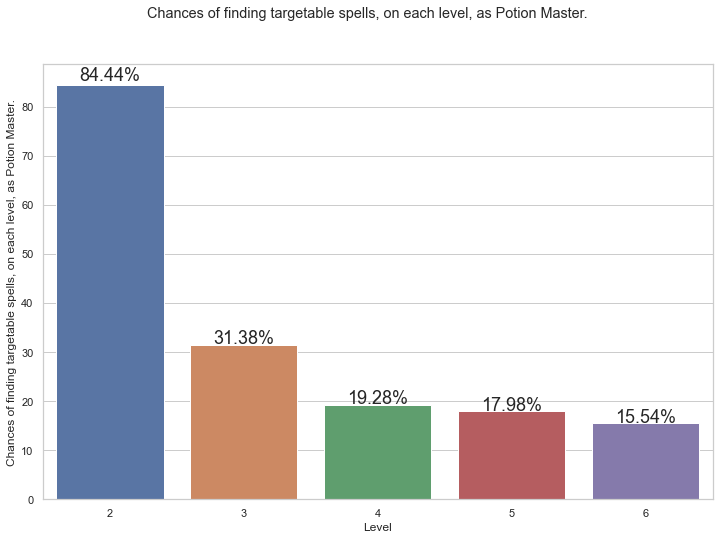

In [107]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(y="Chances of finding targetable spells, on each level, as Potion Master.", x="Level", data=chances)
ax.figure.suptitle("Chances of finding targetable spells, on each level, as Potion Master.")

for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    y_plus = p.get_y() + p.get_height() + (p.get_height()*0.01)
    ax.text(x, y_plus, '{:.2f}%'.format(y), ha='center', size = 18)